# Neural Language Translation using Sequence2Sequence Attention in PyTorch

## Import required libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import random
import time

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

plt.switch_backend('agg')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set the seed value

In [27]:
seed_value = 42 #set the seed value

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
random.seed(seed_value)

## Download & load the data.

The English to French pairs are too big to include in the repository, so download and upload to eng-fra.txt before continuing.

You can download the dataset from here: [Language Translation Data](https://download.pytorch.org/tutorial/data.zip) [Reference: PyTorch dataset]

The file is a tab separated list of translation pairs:

```
we re quite alone =>  nous sommes assez seules.
```

### Set <SOS> for start of the sequence and <EOS> for end of the sequence

In [7]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Language Pair Data Reading and Preprocessing

In [61]:
# Turn a Unicode string to plain ASCII, thanks to- https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [62]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [63]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [64]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['nous ne sommes pas encore sortis de l auberge', 'we re not out of the woods yet']


> #### Note: Since Reverse is True:
>
> Our input is: French and
> Our output is: Englsih text

# Sequence to Sequence - Attention

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

## Encoder Block Workflow

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU. The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence.

![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)

In [65]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Initialize an embedding layer for converting input indexes to dense vectors
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Create a Gated Recurrent Unit (GRU) layer with the specified hidden size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        # Pass the embedded vectors through the GRU layer
        # 'output' contains the GRU outputs for each time step in the sequence
        # 'hidden' is the final hidden state of the GRU after processing the sequence
        output, hidden = self.gru(embedded)
        return output, hidden

## Decoder Block

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the **Context vector** as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.


![decoder](https://pytorch.org/tutorials/_images/decoder-network.png)

In [68]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        # Start-of-sequence token
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        ## Initial decoder hidden state is the encoder's final hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output) # Collect the decoder outputs for each time step

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        # Concatenate decoder outputs along the sequence length
        # Apply log softmax to compute token probabilities
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

## Attention model building

The `BahdanauAttention` implements the Bahdanau Attention mechanism, which is a type of attention mechanism commonly used in sequence-to-sequence models, particularly in neural machine translation tasks.

This mechanism allows the model to focus on different parts of the input sequence while generating the output sequence.

In this tutorial, we will be using Bahdanau attention. However, it would be a valuable exercise to explore modifying the attention mechanism to use **Luong attention.**

---



In [69]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

Let's break down the code and its purpose:

1. **Initialization (`__init__` method):**
   - `hidden_size`: This is the size of the hidden states of the sequences being processed by the attention mechanism.
   - Three linear layers are defined as part of the attention mechanism: `Wa`, `Ua`, and `Va`. These layers are used to learn different sets of parameters that are used to compute attention scores.

2. **Forward Pass (`forward` method):**
   - `query`: This represents the current decoder's hidden state. It's the state of the decoder at a specific time step.
   - `keys`: These are the encoder's hidden states, representing the entire input sequence.

   The goal of the Bahdanau Attention mechanism is to compute attention scores for each time step of the encoder and determine which parts of the input sequence are more relevant for generating the current output.

   - `self.Wa(query) + self.Ua(keys)`: This part calculates an intermediate value by summing the linear transformations of the decoder's hidden state and the encoder's hidden states. This helps the model to align the current decoder state with the encoder states.

   - `torch.tanh(...)`: The intermediate value is then passed through the hyperbolic tangent activation function to ensure that the values fall within a certain range.

   - `self.Va(...)`: The tanh-activated intermediate value is further passed through the third linear layer, which produces attention scores for each time step in the input sequence.

   - `scores.squeeze(2).unsqueeze(1)`: This reshapes the attention scores tensor to have a shape of `(batch_size, 1, sequence_length)`, where `sequence_length` is the length of the input sequence.

   - `F.softmax(...)`: The softmax function is applied to the attention scores along the sequence length dimension, resulting in attention weights that sum to 1 across the input sequence.

   - `torch.bmm(...)`: This performs a batch matrix multiplication between the attention weights and the encoder's hidden states. It computes the context vector, which is a weighted sum of the encoder's hidden states based on the attention weights.

   Finally, the `context` vector and the computed attention `weights` are returned.

## Attention Model Workflow

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [70]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Prepare Data using TensorDataset to fit in Model

In [71]:
#eturns a list of indexes corresponding to the words in the sentence using the word2index mapping
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#define the func above to create input and target tensors for the entire dataset of language pairs.
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Training- Model Train

In [72]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [73]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [74]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [75]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Model Evaluation

In [76]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [77]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Train the Model

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
2m 53s (- 2m 53s) (5 50%) 1.5319
5m 36s (- 0m 0s) (10 100%) 0.6740


<Figure size 640x480 with 0 Axes>

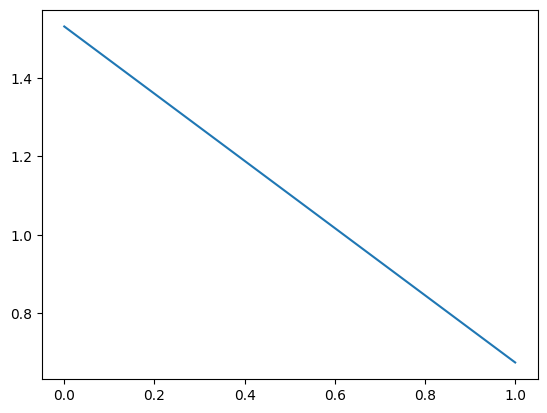

In [78]:
hidden_size = 128
batch_size = 32
epochs = 10

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

%matplotlib inline
train(train_dataloader, encoder, decoder, epochs, print_every=5, plot_every=5)

## Predictions on test data- Evaluation

In [33]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> nous craignons de manquer notre train
= we re afraid we ll miss our train
< we are sorry we can t know the job <EOS>

> je suis myope
= i m nearsighted
< i m tired <EOS>

> ils sont vieux
= they re old
< they are old enough <EOS>

> nous sommes toutes differentes
= we re all different
< we re all different <EOS>

> vous etes sur la liste
= you re on the list
< you re on the list right now <EOS>

> je saigne gravement
= i m bleeding badly
< i m going to hide somewhere near <EOS>

> il n est pas parfait
= he isn t perfect
< he s not perfect <EOS>

> tu es egoiste
= you re selfish
< you re rude talented timid sneaky overworked amazing amazing important

> aujourd hui elle va beaucoup mieux qu hier
= she s much better today than yesterday
< she is much better today than i am <EOS>

> ils courent dans le parc
= they are running in the park
< they are running in the park <EOS>



## Optional - Visualization on how Attention focuses on the text sequence

In [52]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [55]:
import warnings
warnings.filterwarnings("ignore")

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


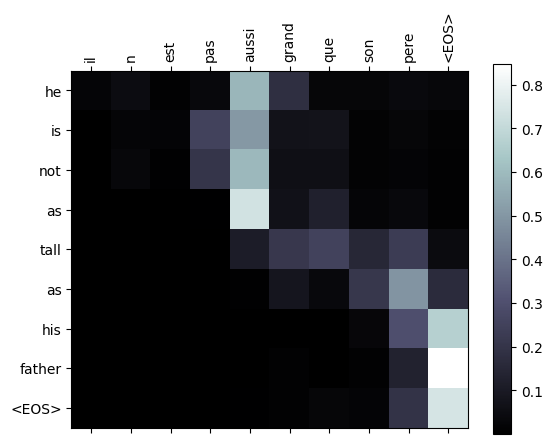

In [56]:
%matplotlib inline
evaluateAndShowAttention('il n est pas aussi grand que son pere')

input = je suis reellement fiere de vous
output = i m really proud of you all you <EOS>


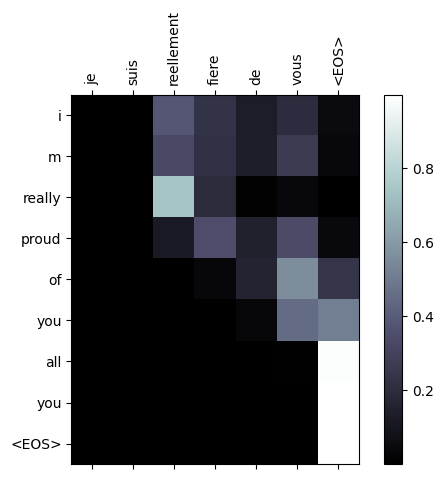

In [79]:
%matplotlib inline
evaluateAndShowAttention('je suis reellement fiere de vous')

## Refernce

- [PyTorch documentation](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)